# Week 7.2 Assignment
- Joshua Burden
- Bellevue University
- DSC550 Data Mining
- Dr. Brett Werner
- 10/16/2022

# Part 1: PCA and Variance Threshold in a Linear Regression
### 1. Import the housing data as a data frame and ensure that the data is loaded properly.

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree as t
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from numpy import array 

In [34]:

df = pd.read_csv('./DATA/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2. Drop the "Id" column and any features that are missing more than 40% of their values.

In [57]:
# Determine columns missing  40% of their values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
MSSubClass,MSSubClass,0.0
MSZoning,MSZoning,0.0
LotFrontage,LotFrontage,0.0
LotArea,LotArea,0.0
Street,Street,0.0
...,...,...
MoSold,MoSold,0.0
YrSold,YrSold,0.0
SaleType,SaleType,0.0
SaleCondition,SaleCondition,0.0


In [35]:
# Drop the "Id" column
df = df.drop(['Id'], axis=1)

# Validate the transformation was successful
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Establish a variable for the 40% threshold
perc = 40.0

# Calculate the minimum non NaN values needed to remain in the dataset
min_count = int(((100-perc)/100)*df.shape[0])

# Remove columsn with more than 40% NaN
df = df.dropna(axis=1, thresh=min_count)

# Validate the transformation was successful
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [58]:
df.shape

(1460, 80)

### 3. For numerical columns, fill any missing data with the median value

In [36]:

numerical_columns = df.select_dtypes(include=['number']).columns

for column in numerical_columns:
    median = df[column].median()
    df[column] = df[column].fillna(median)

### 4. For categorical columns, fill in any missing data with the most common value (mode).


In [50]:
cols = df.columns
categorical_columns = list(set(cols)-set(numerical_columns))
for column in categorical_columns:
    mode = df[column].mode()
    df[column] = df[column].fillna(mode)

### 5. Convert the categorical columns to dummy variables.

In [38]:
df_dummies = pd.get_dummies(df, columns=categorical_columns)
df_dummies.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,1,0,0,0,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,1,0,0,1,0,0,0,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,1,0,0,0,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,1,0,0,0,0,0,0,1,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,1,0,0,1,0,0,0,0


### 6. Split the data into a training and test set, where the SalePrice column is the target.

In [39]:
# Create x & y arrays
x = df_dummies.drop('SalePrice', axis=1)
y = df_dummies['SalePrice']

# Create training & test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

### 7. Run a linear regression and report the R2-value and RMSE on the test set.

In [41]:

# Create a model
model = LinearRegression()
model.fit(x_train, y_train)

# Build predictions
test_predictions = model.predict(x_test)

# Calculate metrics
print('Test Metrics:')
print('R2', metrics.r2_score(y_test, test_predictions))
print('RMSE', metrics.mean_squared_error(y_test, test_predictions, squared=False))

Test Metrics:
R2 0.7336775561011084
RMSE 37216.40898473487


### 8. Fit and transform the training features with a PCA so that 90% of the variance is retained (see section 9.1 in the Machine Learning with Python Cookbook).

In [42]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
pca = PCA(n_components=0.9, whiten=True)
x_train_pca = pca.fit_transform(x_train_scaled)

### 9. How many features are in the PCA-transformed matrix?

In [43]:
x_train_pca.shape

(1168, 148)

There are 140 features

### 10. Transform but DO NOT fit the test features with the same PCA.

In [51]:
x_test_scaled = scaler.transform(x_test)
x_test_pca = pca.transform(x_test_scaled)

### 11. Repeat step 7 with your PCA transformed data.

In [49]:
# Create a model
model_pca = LinearRegression()
model_pca.fit(x_train_pca, y_train)

# Build predictions
test_predictions_pca = model_pca.predict(x_test_pca)

# Calculate metrics
print('Test Metrics:')
print('R2', metrics.r2_score(y_test, test_predictions_pca))
print('RMSE', metrics.mean_squared_error(y_test, test_predictions_pca, squared=False))

Test Metrics:
R2 0.815661917786432
RMSE 30962.64934955817


### 12. Take your original training features (from step 6) and apply a min-max scaler to them.

In [47]:
minmax = MinMaxScaler()
x_train_minmax = minmax.fit_transform(x_train)

### 13. Find the min-max scaled features in your training set that have a variance above 0.1 (see Section 10.1 in the Machine Learning with Python Cookbook).

In [48]:
thresholder = VarianceThreshold(threshold = 0.1)
x_train_high_var = thresholder.fit_transform(x_train_minmax)

### 14. Transform but DO NOT fit the test features with the same steps applied in steps 11 and 12.

In [19]:
x_test_minmax = minmax.transform(x_test)
x_test_high_var = thresholder.transform(x_test_minmax)

### 15. Repeat step 7 with the high variance data.


In [21]:
# Create a model
model_high_var = LinearRegression()
model_high_var.fit(x_train_high_var, y_train)

# Build predictions
test_predictions_high_var = model_high_var.predict(x_test_high_var)

# Calculate metrics
print('Test Metrics:')
print('R2', metrics.r2_score(y_test, test_predictions_high_var))
print('RMSE', metrics.mean_squared_error(y_test, test_predictions_high_var, squared=False))

Test Metrics:
R2 0.6899306944813162
RMSE 44173.51616075865


### 16. Summarize your findings.
- The PCA transformation allowed the model to significantly reduce the number of features while still maintaining most of the model's performance.
- The High Variance model allowed for an even greater reduction in the number of features in the model, however the model's performance was impacted signficiantly.

# Part 2: Categorical Feature Selection
### 1. Import the data as a data frame and ensure it is loaded correctly.


In [52]:
mdf = pd.read_csv(r'./DATA/mushrooms.csv')
mdf.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### 2. Convert the categorical features (all of them) to dummy variables.


In [53]:
mdf_class = mdf['class']
mdf = mdf.drop('class', axis=1)
mdf_dummies = pd.get_dummies(mdf)
mdf_dummies.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


### 3. Split the data into a training and test set.


In [54]:
# create variables for x,y
mx = mdf_dummies
my = mdf_class

# Create training & test datasets
mx_train, mx_test, my_train, my_test = train_test_split(mx, my, test_size = 0.2)


### 4. Fit a decision tree classifier on the training set.


In [55]:
decisiontree = DecisionTreeClassifier(random_state=0)

# Train model
dt_model = decisiontree.fit(mx_train, my_train)


### 5. Report the accuracy and create a confusion matrix for the model prediction on the test set.


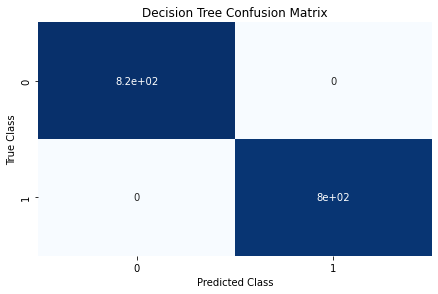

In [56]:
# Build predictions
my_test_pred = dt_model.predict(mx_test)

# Calculate accuracy
accuracy_score(my_test, my_test_pred)
1.0

# Create confusion matrix
matrix = confusion_matrix(my_test, my_test_pred)

# Create pandas dataframe
c_df = pd.DataFrame(matrix)

# Create heatmap
sns.heatmap(c_df, annot=True, cbar=None, cmap="Blues")
plt.title("Decision Tree Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

### 6. Create a visualization of the decision tree.

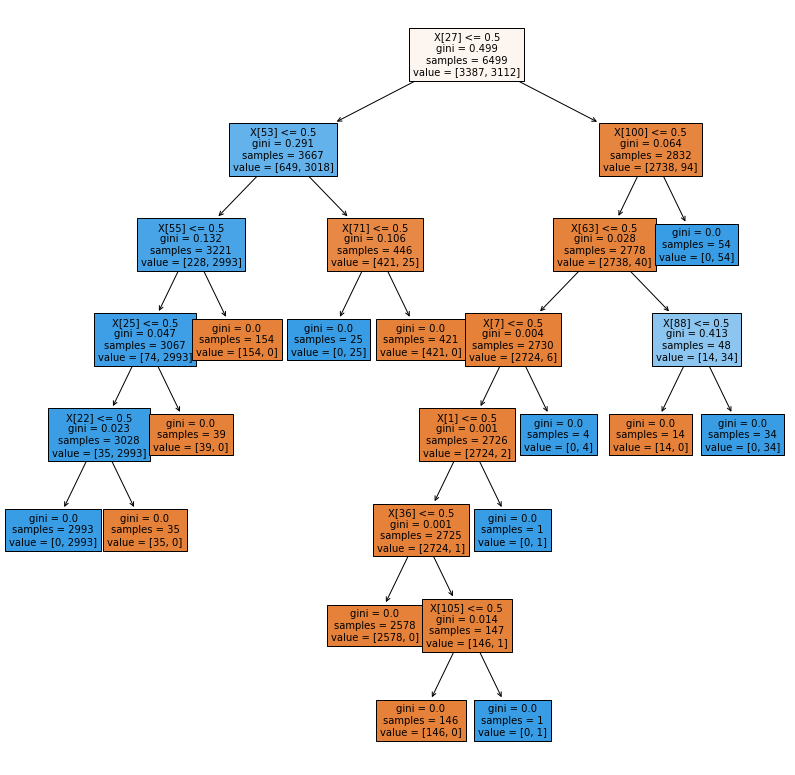

In [68]:
# Plot decision tree
plt.figure(figsize=(14,14))

t.plot_tree(dt_model, filled=True, fontsize=10)
plt.show()


### 7. Use a χ2-statistic selector to pick the five best features for this data (see section 10.4 of the Machine Learning with Python Cookbook).


In [29]:

# Select 5 features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=5)
features_kbest = chi2_selector.fit_transform(mx_train, my_train)



### 8. Which five features were selected in step 7? Hint: Use the get_support function.


In [30]:

# Get all features
features = array(mx_train.columns)

# Get selected features
filter = chi2_selector.get_support()

# Print Features
print(features[filter])

['odor_f' 'odor_n' 'gill-color_b' 'stalk-surface-above-ring_k'
 'stalk-surface-below-ring_k']



### 9. Repeat steps 4 and 5 with the five best features selected in step 7.


In [31]:
# Creat object
decisiontree_5 = DecisionTreeClassifier(random_state=0)

# Train model
dt_5_model = decisiontree_5.fit(features_kbest, my_train)
# Fit test data
dt_5_test = chi2_selector.transform(mx_test)

# Build predictions
dt_5_test_pred = dt_5_model.predict(dt_5_test)

# Calculate accuracy
accuracy_score(my_test, dt_5_test_pred)


0.9273846153846154

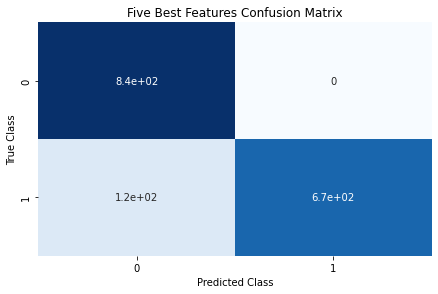

In [32]:

# Create confusion matrix
dt_5_matrix = confusion_matrix(my_test, dt_5_test_pred)

# Create pandas dataframe
c_dt5 = pd.DataFrame(dt_5_matrix)

# Create heatmap
sns.heatmap(c_dt5, annot=True, cbar=None, cmap="Blues")
plt.title("Five Best Features Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

### 10. Summarize your findings.


Using only the five best features allowed us to significantly reduce our dataset while only losing ~7% accuracy